In [1]:
# Download Bach Cello Suite MIDI Files - EXACT folder structure for original notebook
import os
import requests

# Create the exact folder structure the notebook expects
os.makedirs('/content/app/data/bach-cello', exist_ok=True)

# Bach cello suite MIDI files from jsbach.net
bach_files = [
    'cs1-1pre.mid', 'cs1-2all.mid', 'cs1-3cou.mid', 'cs1-4sar.mid', 'cs1-5men.mid', 'cs1-6gig.mid',
    'cs2-1pre.mid', 'cs2-2all.mid', 'cs2-3cou.mid', 'cs2-4sar.mid', 'cs2-5men.mid', 'cs2-6gig.mid',
    'cs3-1pre.mid', 'cs3-2all.mid', 'cs3-3cou.mid', 'cs3-4sar.mid', 'cs3-5bou.mid', 'cs3-6gig.mid',
    'cs4-1pre.mid', 'cs4-2all.mid', 'cs4-3cou.mid', 'cs4-4sar.mid', 'cs4-5bou.mid', 'cs4-6gig.mid',
    'cs5-1pre.mid', 'cs5-2all.mid', 'cs5-3cou.mid', 'cs5-4sar.mid', 'cs5-5gav.mid', 'cs5-6gig.mid',
    'cs6-1pre.mid', 'cs6-2all.mid', 'cs6-3cou.mid', 'cs6-4sar.mid', 'cs6-5gav.mid', 'cs6-6gig.mid'
]

print('Downloading Bach Cello Suite MIDI files...')
base_url = 'http://www.jsbach.net/midi/'

for filename in bach_files:
    try:
        url = base_url + filename
        response = requests.get(url)
        if response.status_code == 200:
            with open(f'/content/app/data/bach-cello/{filename}', 'wb') as f:
                f.write(response.content)
            print(f'✓ Downloaded {filename}')
        else:
            print(f'✗ Failed to download {filename}')
    except Exception as e:
        print(f'✗ Error downloading {filename}: {e}')

print(f'🚀 Done! Downloaded {len(os.listdir("/content/app/data/bach-cello"))} files to /content/app/data/bach-cello/')

✓ Downloaded cs1-1pre.mid
✓ Downloaded cs1-2all.mid
✓ Downloaded cs1-3cou.mid
✓ Downloaded cs1-4sar.mid
✓ Downloaded cs1-5men.mid
✓ Downloaded cs1-6gig.mid
✓ Downloaded cs2-1pre.mid
✓ Downloaded cs2-2all.mid
✓ Downloaded cs2-3cou.mid
✓ Downloaded cs2-4sar.mid
✓ Downloaded cs2-5men.mid
✓ Downloaded cs2-6gig.mid
✓ Downloaded cs3-1pre.mid
✓ Downloaded cs3-2all.mid
✓ Downloaded cs3-3cou.mid
✓ Downloaded cs3-4sar.mid
✓ Downloaded cs3-5bou.mid
✓ Downloaded cs3-6gig.mid
✓ Downloaded cs4-1pre.mid
✓ Downloaded cs4-2all.mid
✓ Downloaded cs4-3cou.mid
✓ Downloaded cs4-4sar.mid
✓ Downloaded cs4-5bou.mid
✓ Downloaded cs4-6gig.mid
✓ Downloaded cs5-1pre.mid
✓ Downloaded cs5-2all.mid
✓ Downloaded cs5-3cou.mid
✓ Downloaded cs5-4sar.mid
✓ Downloaded cs5-5gav.mid
✓ Downloaded cs5-6gig.mid
✓ Downloaded cs6-1pre.mid
✓ Downloaded cs6-2all.mid
✓ Downloaded cs6-3cou.mid
✓ Downloaded cs6-4sar.mid
✓ Downloaded cs6-5gav.mid
✓ Downloaded cs6-6gig.mid
🚀 Done! Downloaded 36 files to /content/app/data/bach-cello/


# 🎶 Music Generation with Transformers

In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

In [2]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

## 0. Parameters <a name="parameters"></a>

In [3]:
PARSE_MIDI_FILES = True
os.makedirs('/content/app/notebooks/11_music/01_transformer/parsed_data/', exist_ok=True)
PARSED_DATA_PATH = "/content/app/notebooks/11_music/01_transformer/parsed_data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. Prepare the Data

In [4]:
# Load the data
file_list = glob.glob("/content/app/data/bach-cello/*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [5]:
parser = music21.converter

In [6]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [7]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x795b8e43af50>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark adagio Quarter=55>
    {0.0} <music21.key.Key of E- major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord C2 C3>
    {1.0} <music21.chord.Chord C3>
    {1.25} <music21.chord.Chord G2>
    {1.5} <music21.chord.Chord A2>
    {1.75} <music21.chord.Chord B2>
    {2.0} <music21.chord.Chord C3>
    {2.25} <music21.chord.Chord D3>
    {2.5} <music21.chord.Chord E-3>
    {2.75} <music21.chord.Chord F3>
    {3.0} <music21.chord.Chord E-3>
    {3.25} <music21.chord.Chord D3>
    {3.5} <music21.chord.Chord E-3>
    {3.75} <music21.chord.Chord C3>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord C2 B2 F3 G#3>
    {1.5} <music21.chord.Chord G#3>
    

In [8]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /content/app/data/bach-cello/cs1-1pre.mid


/tmp/ipython-input-8-3287489010.py:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


658 notes parsed
2 Parsing /content/app/data/bach-cello/cs5-1pre.mid
1967 notes parsed
3 Parsing /content/app/data/bach-cello/cs6-4sar.mid
2302 notes parsed
4 Parsing /content/app/data/bach-cello/cs3-5bou.mid
3183 notes parsed
5 Parsing /content/app/data/bach-cello/cs1-3cou.mid
4003 notes parsed
6 Parsing /content/app/data/bach-cello/cs1-4sar.mid
4266 notes parsed
7 Parsing /content/app/data/bach-cello/cs3-3cou.mid
5255 notes parsed
8 Parsing /content/app/data/bach-cello/cs2-6gig.mid
5990 notes parsed
9 Parsing /content/app/data/bach-cello/cs1-5men.mid
6637 notes parsed
10 Parsing /content/app/data/bach-cello/cs6-5gav.mid
7443 notes parsed
11 Parsing /content/app/data/bach-cello/cs2-5men.mid
7970 notes parsed
12 Parsing /content/app/data/bach-cello/cs4-1pre.mid
8787 notes parsed
13 Parsing /content/app/data/bach-cello/cs3-1pre.mid
9768 notes parsed
14 Parsing /content/app/data/bach-cello/cs2-3cou.mid
10509 notes parsed
15 Parsing /content/app/data/bach-cello/cs2-2all.mid
11202 notes pa

In [9]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 START E-:major 4/4TS C3 C3 G2 A2 B2 C3 D3 E-3 F3 E-3 D3 E-3 C3 G#3 G#3 G3 G#3 F3 E-3 F3 D3 E-3 E-3 C3 C3 D3 E-3 D3 D3 E3 B-2 G#2 B-2 G2 F3 C2 C4 C4 C4 C4 C4 B-3 G#3 B-3 G3 G#3 B-3 G#3 ...

Duration string
 0.0 0.0 0.0 1.0 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 1.5 0.5 0.5 0.25 0.25 0.5 0.25 0.25 1.0 1.0 1.25 0.25 0.25 0.25 1.5 0.5 1.0 0.25 0.25 0.25 0.25 1.0 1.0 1.5 0.5 1.0 0.25 0.25 0.25 0.25 0.75 0.25 0.75 0.25 1.0 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [10]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [11]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
        37         9
        43         9
        42         9
        13         4
        13         2
        16         2
        19         2
        18         2
        13         2
         4         2
        10         2


In [12]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 0.0


## 3. Create the Training Set <a name="create"></a>

In [13]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [14]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 4, 10, 11, ...,  4, 13, 20],
       [10, 11,  2, ..., 13, 20,  4],
       [11,  2,  5, ..., 20,  4,  5],
       ...,
       [17, 23, 15, ..., 23, 15,  3],
       [23, 15, 17, ..., 15,  3, 17],
       [15, 17, 15, ...,  3, 17, 15]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 3, 3, 2],
       [2, 2, 2, ..., 3, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 3, 3, 2],
       [2, 2, 2, ..., 3, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[10, 11,  2, ..., 13, 20,  4],
       [11,  2,  5, ..., 20,  4,  5],
       [ 2,  5, 10, ...,  4,  5, 14],
       ...,
       [23, 15, 17, ..., 15,  3, 17],
       [15, 17, 15, ...,  3, 17, 15],
       [17, 15, 17, ..., 17, 15, 36]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 3, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,

## 5. Create the causal attention mask function <a name="causal"></a>

In [15]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [16]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [17]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

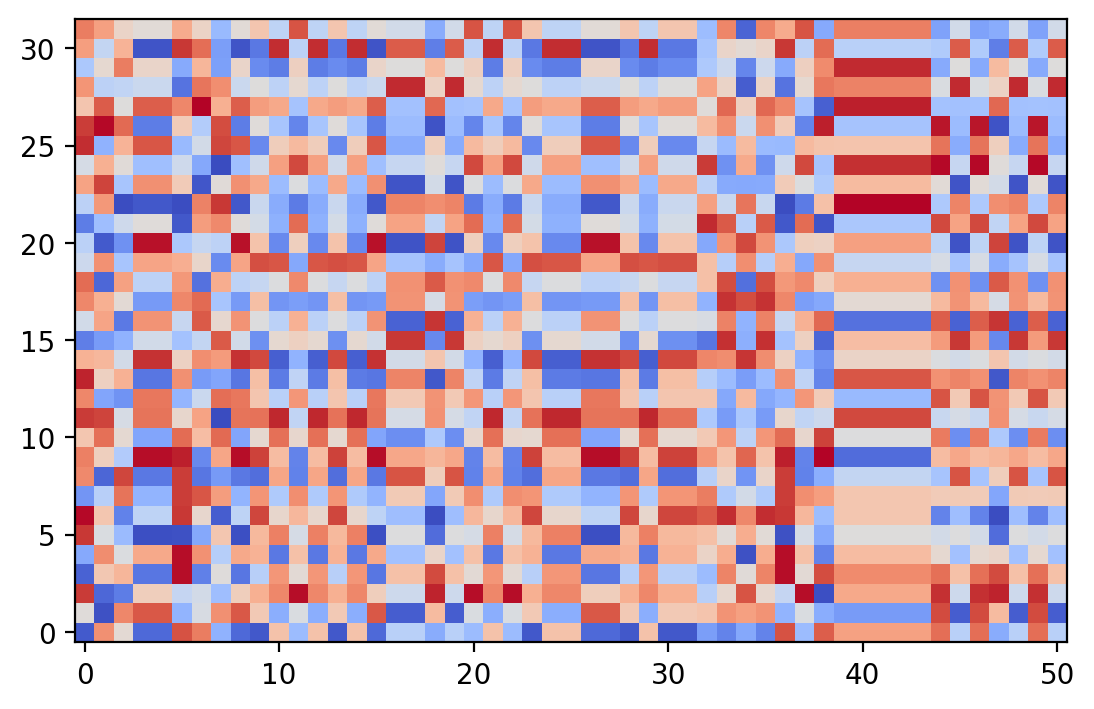

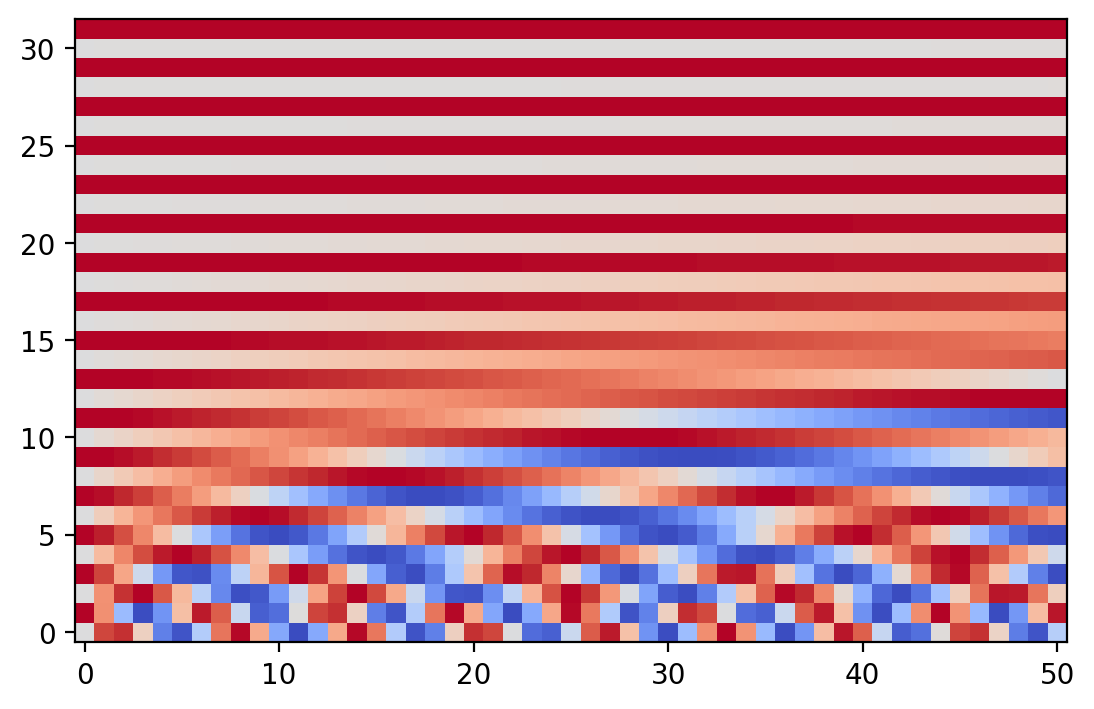

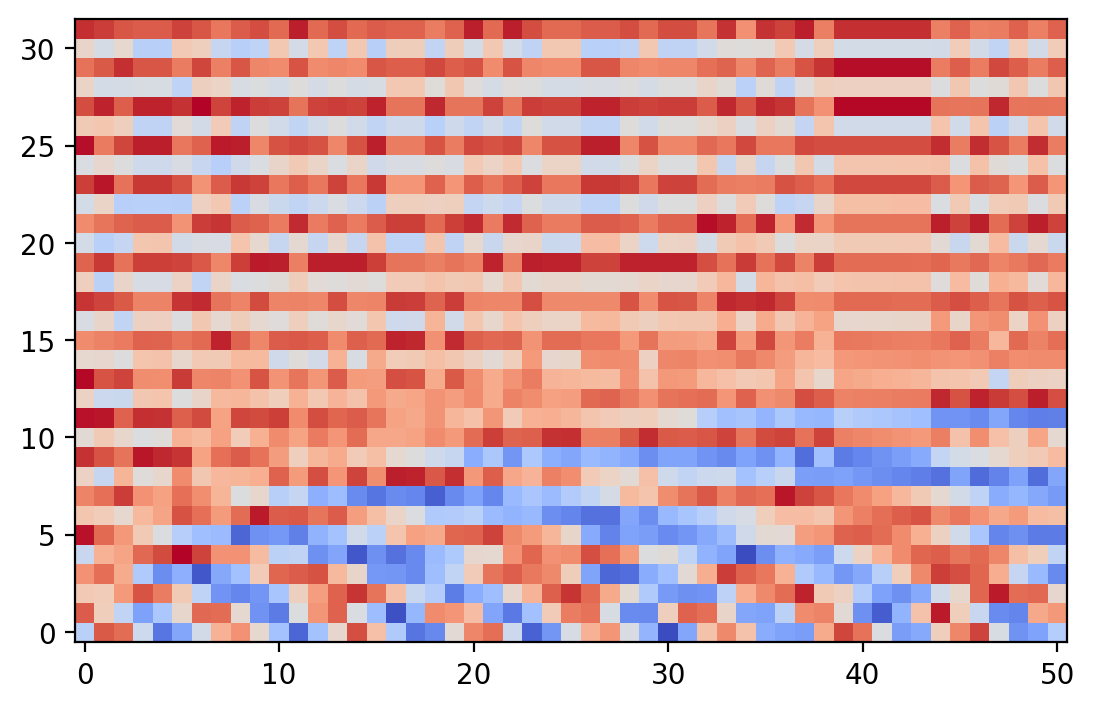

In [18]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [19]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 128) │      7,552 │ input_layer[0][0] │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 128) │      3,072 │ input_layer_1[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 256) │          0 │ token_and_positi… │
│ (Concatenate)       │                   │            │ token_and_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ [(None, None,     │  1,447,424 │ concatenate[0][0] │
│ (TransformerBlock)  │ 256), (None, 5,   │            │                   │
│                     │ None, None)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_outputs        │ (None, None, 59)  │     15,163 │ attention[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_outputs    │ (None, None, 24)  │      6,168 │ attention[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,479,379 (5.64 MB)

 Trainable params: 1,479,379 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
if LOAD_MODEL:
    model.load_weights("./checkpoint/checkpoint.ckpt")
    # model = models.load_model('./models/model', compile=True)

## 9. Train the Transformer <a name="train"></a>

In [22]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False


            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        # midi_stream.show()
        output_dir = "/content/app/notebooks/11_music/01_transformer/output"
        os.makedirs(output_dir, exist_ok=True) # Add this line to create the directory
        midi_stream.write(
            "midi",
            fp=os.path.join(
                output_dir,
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [23]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [ ]:
os.makedirs("/content/app/notebooks/11_music/01_transformer/output", exist_ok=True)
model.fit(
    ds,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator,
    ],
)

Epoch 1/5
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - duration_outputs_loss: 1.1221 - loss: 4.6407 - note_outputs_loss: 3.5186

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


[['START', np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('F2'), np.str_('E-3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('F3'), np.str_('B-2'), np.str_('E-3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('F3'), np.str_('F3'), np.str_('G3'), np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('F3'), np.str_('D3'), np.str_('C3'), np.str_('E-3'), np.str_('F3'), np.str_('B-2'), np.str_('D3'), np.str_('F3'), np.str_('F3'), np.str_('D3'), np.str_('E-3'), np.str_('F3'), np.str_('E-3'), np.str_('F3'), np.str_('D3'), np.str_('B-2'), np.str_('F3'), np.str_('E-3'), np.str_('D3'), np.str_('F3'), np.str_('E-3')], ['0.0', np.str_('0.75'), np.str_('0.25'), np.str_('0.25'), np.str_('0.25'), np.str_('0.25'), np.str_('0.25'), np.str_('0.25'), np.str_('0.25'), np.str_('0.25'), np.str_('0.25'), np.str_('0.25'), np.str_('0.25'), np.str_('0.25'), np.str_('0.25'), np.str_

In [ ]:
# Save the final model
os.makedirs('./models', exist_ok=True)
model.save("./models/model")

# 3. Generate music using the Transformer

In [ ]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()

## Write music to MIDI file

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/app/notebooks/11_music/01_transformer/output",
        "output-" + timestr + ".mid",
    ),
)

## Note probabilities

In [ ]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## Attention Plot

In [ ]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [ ]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()